<a href="https://colab.research.google.com/github/Henning-Kubatzsch/Tutorials/blob/main/Built_GPT/GPT_FromScratch_Short.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT - Genera Pretrained Transformer

**Transformer:**

* A type of neural network
* Handles all the heavy lifting internally
* Introduced in the paper *“Attention Is All You Need”*


# What this Colab is about

**Training a Transformer on Shakespeare’s Works (1MB):**

* Feed the full text into a Transformer to model character sequences.
* Given a block of previous characters (context), the model predicts the next character.
* Over time, it learns to generate text that mimics Shakespeare — capturing patterns, style, and even basic plot and character roles.

**Output Example:**

* The model produces Shakespeare-like language:
  *“Verily, my lord! the sights have left thee again the king, coming with my curses with precious pale.”*

**Details:**

* Characters are generated token by token.
* Tokens are subword-level (not full words, but chunks of words).

---

**What We're Building:**

We're building [nanoGPT](https://github.com/karpathy/nanoGPT) from scratch — a minimal Transformer training framework:

* Just 2 Python files (\~300 lines each):

  * One defines the GPT model (the Transformer).
  * The other handles training on any text input.
* Originally trained on OpenWebText (a large web crawl dataset).
* Achieves performance comparable to GPT-2 (2017).
* Can also load OpenAI’s released model weights.


# Load the data

In [1]:
# we alaways start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-06-04 16:04:03--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2025-06-04 16:04:04 (34.3 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
# read it in and indpect it
with open('input.txt', 'r', encoding='utf-8') as f:
  text = f.read()

In [3]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


# Work with the source - built vocabulary

## Acces the text

In [4]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



## Create Charset

In [5]:
# here are all the unique characters that occcur in the text
# set(text): get all the characters in the text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
print(set(text))
print(list(set(text)))
print(sorted(list(set(text))))

{'w', 'U', ',', 't', ':', 'S', 'A', 'a', 'F', 'J', 'L', 'W', 'K', 'X', 'R', 'j', 'H', '&', '!', 'u', 'B', 'G', 'z', 'Z', 'h', ';', '\n', '$', 'e', 'x', 'p', 'Y', '3', 'I', 'E', 'C', '-', 'g', 'O', '?', 'o', 'm', 'k', 'M', 'b', 'T', 'D', 'q', 'Q', 'f', 'V', 'c', 'n', 'P', ' ', 'y', 's', '.', "'", 'l', 'd', 'i', 'r', 'N', 'v'}
['w', 'U', ',', 't', ':', 'S', 'A', 'a', 'F', 'J', 'L', 'W', 'K', 'X', 'R', 'j', 'H', '&', '!', 'u', 'B', 'G', 'z', 'Z', 'h', ';', '\n', '$', 'e', 'x', 'p', 'Y', '3', 'I', 'E', 'C', '-', 'g', 'O', '?', 'o', 'm', 'k', 'M', 'b', 'T', 'D', 'q', 'Q', 'f', 'V', 'c', 'n', 'P', ' ', 'y', 's', '.', "'", 'l', 'd', 'i', 'r', 'N', 'v']
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Those are now all the charaters the model can see or emit

# Tokenize the input text - built encoder/ decoder

## Built Decoder/ Encoder

Convert raw text (a string) into a sequence of integers using a vocabulary or lookup table.

Example:

* For a character-level language model, map each individual character to a unique integer.


In [7]:
# create a mapping from charaters to integers
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, outpur a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


## How others use Tokenizers

**Google SentencePiece:**

* Encodes text into integers using a different scheme and vocabulary.
* It’s a **subword tokenizer** — neither full words nor single characters, but pieces of words.
* This approach is widely used in practice.

**Example — OpenAI’s tiktoken:**

* A Byte Pair Encoding (BPE) tokenizer used by GPT models.
* Vocabulary size: 50,257 tokens.

```python
import tiktoken

enc = tiktoken.get_encoding('gpt2')
print(enc.n_vocab)                  # 50257
print(enc.encode("hii there"))      # [71, 4178, 612]
print(enc.decode([71, 4178, 612]))  # 'hii there'
```

---

This is the standard method GPT uses for tokenizing input text.


But in our case we gonna keep it simple and use character level tokenizer. That means we have very small code books. Very simple encode and decode functions. But we get very long sequences as a result.

## Encode the whole Text

In [8]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape)
print(data.dtype)
print(data[:1000]) # the 1000 characters we looked at ealier will look to GPT like this

torch.Size([1115394])
torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

# Building Datasets: Train, Validation

In [9]:
# Let's now split up the data into train and validation sets
n = int(0.9 * len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# Feeding the Transformers

## Inputs and Targets

We never feed the entire text into a Transformer at once—it would be too computationally expensive.
Instead, during training, we feed random small chunks (batches) of the dataset.
Each chunk has a fixed maximum length called `block_size` or `context_length`.


In [10]:
block_size = 8
t = train_data[:block_size+ 1]
t

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

You can view a chunk as a batch containing multiple examples packed together, where the characters follow one another sequentially.
Feeding this chunk to the Transformer lets us train it to predict the next character at every position simultaneously.

---


**Example:**

* A chunk of 9 characters contains 8 training examples, each predicting the next character.

* Given context `18`, the model predicts `47` next.

* Given context `[18, 47]`, the model predicts `56` next.

* And so on…


**Spelled out with code**

In [11]:
x = train_data[:block_size]
y = train_data[1:block_size + 1]
for t in range(block_size):

  context = x[:t+1]
  target = y[t]
  print(f'{t}th iteration. when input is {context} the target: {target}')

0th iteration. when input is tensor([18]) the target: 47
1th iteration. when input is tensor([18, 47]) the target: 56
2th iteration. when input is tensor([18, 47, 56]) the target: 57
3th iteration. when input is tensor([18, 47, 56, 57]) the target: 58
4th iteration. when input is tensor([18, 47, 56, 57, 58]) the target: 1
5th iteration. when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
6th iteration. when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
7th iteration. when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


---

x: input to the transformer

y: next charater

---

By feeding the Transformer varying context lengths—from as short as one token up to the full `block_size`—we train it to handle different amounts of context.

If the input exceeds `block_size`, we must truncate it, since the Transformer can only attend to up to `block_size` tokens when predicting the next character.


---

**block\_size:**

* The length of the time dimension fed into the Transformer.

We also need to consider the **batch dimension**, which represents multiple chunks of text stacked together in a single tensor.

This batching is done for efficiency—GPUs excel at parallel processing. Each chunk in the batch is processed independently; they don’t interact or share information.


## Create Batches with batch_dimension and block_size / contex_lenght

In [12]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the macimum context length for predictions?

def get_batch(split):
  #generate a small batch of data of inputs x and targets y
  data = train_data if split == "train" else val_data
  ix = torch.randint(len(data) - block_size, (batch_size, ))
  # use stack to take one dimensional tensors and stack them up to rows
  x = torch.stack([data[i:i+block_size] for i in ix])
  y = torch.stack([data[i+1:i+block_size+1] for i in ix])
  return x, y

In [13]:
xb, yb = get_batch('train')
print('inputs:\n')
print(xb.shape)
print(xb)
print('\n')
print('targets:\n')
print(yb.shape)
print(yb)

inputs:

torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


targets:

torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


## Working with the Model

---

**Our approach:**
We choose the simplest network possible — a Bigram Model. From now on, we rely on PyTorch modules instead of manual implementations like in the Makemor Tutorials.

---

**nn.Embedding:**

* Takes `(num_embeddings, embedding_dim)` as input.
* For our vocabulary size (`num_embeddings`), it maps each character to an embedding vector of size `(embedding_dim)`.
* The output from `token_embedding_table` are logits — after appying softmax those give us the emission probabilities over all tokens.

---

**Loss Evaluation:**

* In *makemore*, negative log-likelihood loss is used.
* In PyTorch, use `cross_entropy()` for the loss calculation.


In [14]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Set manual seed for reproducibility
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # Embedding table: each token maps directly to logits for the next token
        # (vocab_size x vocab_size) because we're predicting the next token directly from the current one
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # idx: (B, T) tensor of token indices
        # targets: (B, T) tensor of next-token indices (optional)

        # Get logits for the next token from embedding table
        # Output shape: (B, T, C) where C = vocab_size
        logits = self.token_embedding_table(idx)

        loss = None

        if targets is not None:
            # Flatten the tensors for use with cross-entropy loss
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        """
        Autoregressive generation of new tokens.

        Args:
            idx: (B, T) tensor — current token context for each batch
            max_new_tokens: number of tokens to generate
        Returns:
            idx: (B, T + max_new_tokens) tensor — input extended with generated tokens
        """
        for _ in range(max_new_tokens):
            # Forward pass through model (ignores loss since no targets provided)
            logits, _ = self(idx)

            # Focus only on the last time step's logits: (B, C)
            logits = logits[:, -1, :]

            # Convert logits to probabilities
            probs = F.softmax(logits, dim=1)

            # Sample next token from the probability distribution: (B, 1)
            idx_next = torch.multinomial(probs, num_samples=1)

            # Append sampled token to sequence: (B, T+1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

**Summary of Key Concepts:**

- Embedding table: Directly maps current token to a distribution over next tokens.

- Bigram model: No hidden state; predictions are based only on the current token.

- Generation: Repeatedly sample next token and append to the sequence.

- Loss: Standard cross_entropy, reshaping tensors to 2D for compatibility.

**Expected Loss (Uniform Guessing):**

If our vocabulary has 65 tokens, and the model guesses uniformly at random:

$$
-\ln\left(\frac{1}{65}\right) \approx 4.174
$$

This is the theoretical loss when the model knows nothing and guesses every token with equal probability.

Since our actual loss is slightly higher than this, it means there’s still some **uncertainty (entropy)** in the embedding table — the model is guessing, and often guessing wrong.


In [15]:
# Instantiate the Bigram Language Model
m = BigramLanguageModel(vocab_size)

# Forward pass with training data
logits, loss = m(xb, yb)
print(logits.shape)  # Should be (B*T, vocab_size) after flattening
print(loss.shape)    # Scalar: no shape, just a single value
print(loss)          # Print the actual loss value

# Generate text
# Start with a context of a single token: '\n' (token index 0 assumed)
idx = torch.zeros((1, 1), dtype=torch.long)  # Shape: (B=1, T=1)

# Generate 100 new tokens from the model
generated = m.generate(idx, max_new_tokens=100)

# Decode the generated sequence back into text (remove batch dimension)
print(decode(generated[0].tolist()))

torch.Size([32, 65])
torch.Size([])
tensor(4.8786, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


---

Up to this point, we have a **simple bigram model** that:

* Takes in a **single character at a time** (`logits[:, -1, :]`).
* Predicts the **next character** based only on that one input.

There's **no memory or context beyond one token** — the model is essentially learning the transition probabilities between pairs of characters.


## Start train the model

---

### Create PyTorch Optimizer

We use an optimizer to **update model parameters** based on the computed **gradients** during backpropagation.

Example using Adam:

```python
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)
```

* `m.parameters()`: provides the model parameters to be updated.
* `AdamW`: a commonly used optimizer for Transformers.
* `lr`: learning rate — controls step size in gradient descent.

---

**Workflow:**

1. Forward pass → compute loss
2. `loss.backward()` → compute gradients
3. `optimizer.step()` → update parameters
4. `optimizer.zero_grad()` → clear gradients for the next step


In [16]:
# So far, we only used stochastic gradient descent:
# optimizer = torch.optim.SGD(m.parameters(), lr=...)

# SGD is the simplest optimizer — it updates weights purely based on the gradient direction.
# For more advanced and stable training, especially with larger models, we use AdamW.

# AdamW combines:
# - Adaptive learning rates (like Adam)
# - Weight decay (the 'W' in AdamW), which helps regularize the model

# Rule of thumb:
# - Bigger models → use a lower learning rate
# - Smaller models → can use a higher learning rate

optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)



In [17]:
batch_size = 32
for steps in range(10000):

  # sample a batch of data
  xb, yb = get_batch('train')

  # evaluate the loss
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True) # zeroing all the gradients from the previous step
  loss.backward() # get gradients for all the parameters
  optimizer.step() # use gradients to update the parameters
print(loss.item())

2.5727508068084717


...remember that we still use a bigram model

In [18]:
print(decode(m.generate(idx, max_new_tokens=100)[0].tolist()))


Iyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y helti


# The mathematical trick of self-attention

```
x = train_data[:block_size]
y = train_data[1:block_size + 1]
for t in range(block_size):
  context = x[:t+1]
  target = y[t]
  print(f'{t}th iteration. when input is {context} the target: {target}')
```

In [19]:
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels (some information in the sequence)
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

## Small textual orientation

### **Goal**: Make Tokens Communicate

Currently, each token is processed **independently** — no interaction across time steps.

We want to **introduce context** — make each token aware of **previous tokens**, but **not future ones**.

---

### **Causal Communication Rule**

* Token at position `t` should only attend to positions `≤ t`
* No peeking into the future — this enforces **causality**, critical for autoregressive models

---

### **Example (Contextualizing Token at t = 5):**

* It should aggregate information from tokens at positions 1–5
* Compute a **weighted average** of the vectors at those positions
* This gives a **feature vector** summarizing the token's **past context**

> Note: A simple average would lose spatial/positional information, but we accept that for now.

---

### **What We Want to Do Next:**

* For each batch element independently
* For each token position in the sequence
* Compute the **average** of all token embeddings **up to and including the current position**

This operation is essentially a **lower-triangular attention mask**, and the manual averaging version is a stepping stone toward **self-attention**, which generalizes this with learned weights.


## Version 1: Back to our small example - unefficient and efficient way

In [20]:
# Goal: For each position t in the sequence, compute the mean of all previous vectors up to t
# That is, xbow[b, t] = mean_{i <= t} x[b, i]

xbow = torch.zeros((B, T, C))  # "bow" = bag-of-words; shape: (batch, time, channels)

for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1]        # Select all tokens up to and including time t (shape: (t+1, C))
        xbow[b, t] = xprev.mean(0)  # Average across time dimension → shape: (C,)

### We can also generate the output via Matrix MUL

In [21]:
torch.tril(torch.ones(3,3)) # .tril: triangular -> returns lower triangular portion

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [22]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3,3))
a = a / torch.sum(a, 1, keepdim = True )
b = torch.randint(0, 10, (3,2)).float()
c = a @ b
print('a=')
print(a)
print('b =')
print(b)
print('----')
print('c =')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
b =
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
----
c =
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


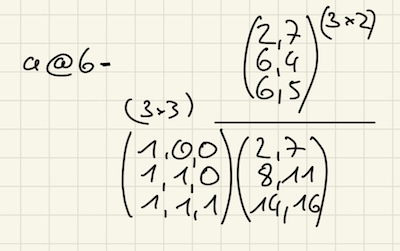

## Version 2: Implement tor torch.tril() for efficient mean

What we are using here is weighted sums

In [23]:
# wei: short form for weights
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim = True)
xbow2 = wei @ x # (T,T) @ (B,T,C) -> (pytorch creates batch dim) (B, T, T) @ (B, T, C) ----> for each batch (T, T) @ (T, C) ----> (B, T, C)
torch.allclose(xbow, xbow2, atol=1e-3) # atol: absolute toleranz

True

## Version 3: Using Softmax

In [24]:
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3, atol = 1e-3)

True

In [25]:
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

---

### Why This Method (Weighted Aggregation via Matrix Multiplication) Is Powerful

* **Weights start at zero** — these represent *affinities* or *interaction strengths* between tokens.

  * They control *how much each token looks at the others*.

```python
wei.masked_fill(tril == 0, float('-inf'))
```

* This applies a **causal mask**, forcing tokens to **only attend to their past** (i.e. prevents future information leakage).
* Setting to `-inf` ensures `softmax` zeroes them out.

---

### Aggregation with Matrix Multiplication

```python
xbow = wei @ x
```

* This line **aggregates past token embeddings**, weighted by `wei`.
* Think of `wei` as an attention map, and this line is doing **weighted sum of token vectors** across the sequence.

---

### Preview of Self-Attention

```python
wei = torch.zeros((T, T))
```

* Right now weights are all uniform, but...
* In real self-attention, weights will be **data-dependent**.

  * Tokens will dynamically decide which others they find "interesting".
  * These **affinities** will vary depending on token content.

```python
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
```

* `softmax` converts affinities into **normalized attention scores**.
* The matrix multiplication aggregates token vectors **based on these scores**.

---

### Key Insight

* A **lower triangular matrix** defines **who can attend to whom**:

```
1 0 0
1 1 0
1 1 1
```

* Row *t* says: “I can see myself and all tokens before me.”
* This trick is the backbone of **causal self-attention**, which we’ll now use to build our attention block.

---

This is the foundation for the **Transformer's attention mechanism**. We’re moving from simple averaging to **learned, content-aware attention**.


## Step by Step example with Softmax

In [26]:
tril = torch.tril(torch.ones(T,T))
tril


tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [27]:
wei1 = torch.zeros(T,T)
wei1

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [28]:
wei1 = wei1.masked_fill(tril == 0, float('-inf'))
wei1

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [29]:
wei1 = F.softmax(wei1, dim=-1) # dim = -1 -> last dimension
wei1

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

Softmax works like a normalization operation. every single value get exponentiatet and we devide it by the sum.

$e^x$

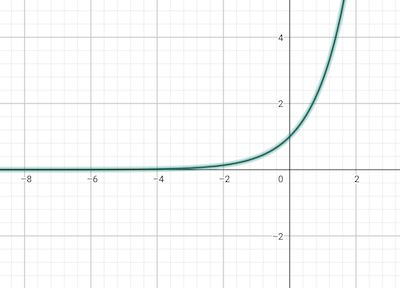

In [30]:
print(x.shape)
xbow4 = wei1 @ x
xbow4

torch.Size([4, 8, 2])


tensor([[[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]],

        [[ 1.3488, -0.1396],
         [ 0.8173,  0.4127],
         [-0.1342,  0.4395],
         [ 0.2711,  0.4774],
         [ 0.2421,  0.0694],
         [ 0.0084,  0.0020],
         [ 0.0712, -0.1128],
         [ 0.2527,  0.2149]],

        [[-0.6631, -0.2513],
         [ 0.1735, -0.0649],
         [ 0.1685,  0.3348],
         [-0.1621,  0.1765],
         [-0.2312, -0.0436],
         [-0.1015, -0.2855],
         [-0.2593, -0.1630],
         [-0.3015, -0.2293]],

        [[ 1.6455, -0.8030],
         [ 1.4985, -0.5395],
         [ 0.4954,  0.3420],
         [ 1.0623, -0.1802],
         [ 1.1401, -0.4462],
         [ 1.0870, -0.4071],
         [ 1.0430, -0.1299],
         [ 1.1138, -0.1641]]])

## Self-Attention: A Single Head

### Motivation: Why Move Beyond Uniform Averaging?

Previously, we simply **averaged all previous tokens** using a fixed lower-triangular matrix (`wei`), leading to *uniform attention*:

```python
torch.zeros((T, T))
```

* Each row had equal weights → simple averaging.
* This ignored the **content of the tokens**.
* But not all tokens are equally relevant!

### The Improvement: Make Attention **Data Dependent**

> **Idea**: A token should dynamically decide *which* other tokens it finds important, based on their content.

Example:

* If the current token is a **vowel**, it may want to focus on **consonants** before it.
* This is where **self-attention** comes in.

---

### How Self-Attention Works

**Each token computes two vectors:''**

| Name    | Description              | Purpose                       |
| ------- | ------------------------ | ----------------------------- |
| `Query` | "What am I looking for?" | Used to find relevant tokens  |
| `Key`   | "What do I contain?"     | Used to match against queries |

### Affinity Calculation:

* For each token, **dot product its query with the keys of all others**.

```python
affinity = query ⋅ keyᵀ
```

* This produces a **(T x T)** matrix of affinities = `wei`.

---

### Code: Self-Attention Head (Core Idea)

In [31]:
head_size = 16  # Hyperparameter: dimensionality of the head

key   = nn.Linear(C, head_size, bias=False)   # Key projection: what the token contains
query = nn.Linear(C, head_size, bias=False)   # Query projection: what the token is looking for

k = key(x)    # (B, T, head_size)
q = query(x)  # (B, T, head_size)

Now compute **raw attention weights** (`wei`) via dot product:


In [32]:
wei = q @ k.transpose(-2, -1)  # (B, T, head_size) @ (B, head_size, T) → (B, T, T)


* `wei[b, i, j]` tells you **how much token `i` attends to token `j`**, based on the alignment of their query and key vectors.

### Summary So Far:

* Tokens independently emit `key` and `query` vectors.
* **No communication** has happened yet.
* But the **dot product between `q` and `k`** builds the attention structure (`wei`), which is:

  * **Dynamic** (content-based)
  * **Learnable**
  * The basis of **contextual information flow**

---

Next up:

* Apply **masking** to ensure causality (no peeking into the future).
* Use **softmax** to convert raw affinities into **attention weights**.
* Aggregate **values** (a third projection) using these weights.


In [33]:
tril = torch.tril(torch.ones(T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, -1)
print(wei.shape)
wei[0]


torch.Size([4, 8, 8])


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4604, 0.5396, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3156, 0.2768, 0.4077, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1895, 0.1548, 0.2793, 0.3764, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1925, 0.1604, 0.1976, 0.2001, 0.2493, 0.0000, 0.0000, 0.0000],
        [0.0987, 0.1366, 0.0596, 0.0406, 0.1290, 0.5354, 0.0000, 0.0000],
        [0.1444, 0.1407, 0.1633, 0.1798, 0.1241, 0.0964, 0.1512, 0.0000],
        [0.0332, 0.0348, 0.0193, 0.0125, 0.0730, 0.1960, 0.0266, 0.6046]],
       grad_fn=<SelectBackward0>)

* The values in each row of the attention weight matrix are not uniform; they vary in strength.
* For example, looking at the last row, focusing on the eighth token:

  * This token “knows” what content it holds.
  * It knows its position in the sequence (position 8).
  * Based on this knowledge, it forms a query that says something like:

    * “Hey, I’m looking for something specific. I’m a vowel at position 8, and I’m interested in any consonants at positions up to 4.”
  * Meanwhile, all other tokens emit their keys. One channel in a key might encode:

    * “I’m a consonant at a position up to 4.”
  * The dot product between the query and each key measures how well they match (their affinity).
* When the affinity is high (for example, the value 0.2297 at position 4 in the last row):

  * The token at position 8 pays special attention to the token at position 4.
  * After applying softmax, the information from position 4 is strongly weighted and aggregated into the representation of position 8.
  * This allows the token at position 8 to learn a lot about the context at position 4.

### Example: Dot-Product Attention for 3 Tokens



Let's define simple `query` and `key` vectors:

```python
q = torch.tensor([
  [1.0, 0.0],  # Token A 'i need a subject'
  [0.0, 1.0],  # Token B 'i need an object'
  [1.0, 1.0],  # Token C 'i need both'
])
k = torch.tensor([
  [1.0, 0.0],  # Token A 'i am a subject'
  [0.0, 1.0],  # Token B 'i am an object'
  [1.0, 1.0],  # Token C 'i am both'
])
```

Now compute raw attention scores:

```python
wei = q @ k.T
```

This gives us a **3×3 matrix** of dot products between each query and each key:

|               | **A (key)** | **B (key)** | **C (key)** |
| ------------- | ----------- | ----------- | ----------- |
| **A (query)** | 1.0         | 0.0         | 1.0         |
| **B (query)** | 0.0         | 1.0         | 1.0         |
| **C (query)** | 1.0         | 1.0         | 2.0         |


#### What's happening?

* Each **row** of `wei` corresponds to **one query** comparing itself to **all keys**.
* This tells you: *how much each token "cares" about every other token*.
* Then, **Softmax** is applied row-wise to turn scores into probabilities.

---

#### Why `q @ k.T` and not `k @ q.T`?

Because **each token (query)** is looking outward and **deciding what to focus on** among the other tokens (keys). You want each row `i` to contain the scores between `q[i]` and all `k[j]`.

If you did `k @ q.T`, you'd flip the logic and answer the question: *“How much does token j want to be looked at by i?”*, which is not the intended behavior in attention mechanisms.



### How `out = wei @ v` Works — In Plain Terms:



Each token is basically asking:

> *“Which other tokens in the sequence might have useful information for me?”*

---

* `wei` (weights) holds the **attention scores** between all pairs of tokens.

  * `wei[i, j]` = how much **token i** pays attention to **token j**
* `v` holds the **information each token is willing to share** (their value vectors)

So when we do:

```python
out = wei @ v
```

…it means:

> For each token **i**, go through **every other token j**, grab their info `v_j`, **weigh it** by how much it cares about j (`w_ij`), and **add it up**.

---

$$
\text{out}_i = \sum_j w_{ij} \cdot v_j
$$


So the output is a **blend** of everyone’s values — but only weighted by how relevant they are to you.

That’s attention.

Each token *builds a new representation* by learning who to listen to.



### Under the Hood

In [34]:
torch.manual_seed(1337)
B,T,C = 4, 8, 32 # batch, time, channels(embedding)
x = torch.randn(B, T, C)

# let's see a single Head perform self-attention
# head_size: we take a 32 dimensional embedding and project it into a 16 dimensional space
head_size = 16  # Hyperparameter
key = nn.Linear(C, head_size, bias = False)   # what do i contain
query = nn.Linear(C, head_size, bias = False) # what am i looking for
value = nn.Linear(C, head_size, bias = False) # what do i have to offer

k = key(x)    # (B, T, head_size)
q = query(x)  # (B, T, head_size)
v = value(x)  # (B, T, head_size)

wei = q @ k.transpose(-2, -1) #(B, T, 16) @ (B, 16, T) --> (B, T, T)


In [35]:
wei[0]

tensor([[-1.7629, -1.3011,  0.5652,  2.1616, -1.0674,  1.9632,  1.0765, -0.4530],
        [-3.3334, -1.6556,  0.1040,  3.3782, -2.1825,  1.0415, -0.0557,  0.2927],
        [-1.0226, -1.2606,  0.0762, -0.3813, -0.9843, -1.4303,  0.0749, -0.9547],
        [ 0.7836, -0.8014, -0.3368, -0.8496, -0.5602, -1.1701, -1.2927, -1.0260],
        [-1.2566,  0.0187, -0.7880, -1.3204,  2.0363,  0.8638,  0.3719,  0.9258],
        [-0.3126,  2.4152, -0.1106, -0.9931,  3.3449, -2.5229,  1.4187,  1.2196],
        [ 1.0876,  1.9652, -0.2621, -0.3158,  0.6091,  1.2616, -0.5484,  0.8048],
        [-1.8044, -0.4126, -0.8306,  0.5899, -0.7987, -0.5856,  0.6433,  0.6303]],
       grad_fn=<SelectBackward0>)

This is the output of the dot products — the raw values — which range from -2 to +2. They represent the interactions and raw affinities between all the nodes.

But if i am a fith node, i will not want to aggregate anything from the sixth, seventh or eighth node. So we use the upper triangular masking

In [36]:
tril =  torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim = -1)
wei[0] # (T,T)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

...and now this is telling us in a data dependent manner how much of information to aggregate from any of these tokens in the past.

In [37]:
# wei[0].sum(-1, keepdim = True)

In [38]:
out = wei @ v
out.shape

torch.Size([4, 8, 16])

In [39]:
x[0].shape

torch.Size([8, 32])

**So what is `x`?**

```python
torch.manual_seed(1337)
B, T, C = 4, 8, 32  # Batch size, Time steps, Embedding size (channels)
x = torch.randn(B, T, C)
```

You can think of `x` as a tensor containing the **individual "thoughts" or "states" of each token** in a sequence — across multiple sequences (batches).
Each token has its **own private vector** — its **embedding** — which holds all the information it knows about itself *before* any communication happens.

---

#### Imagine the 5th token speaking:

>"I am the 5th token in the sequence. I have my own identity, stored in my embedding vector from `x`. Now, if we’re about to talk to each other (like in attention), I’ll form a question about what I want to know (that’s my **query**), I’ll describe myself so others can judge if I’m relevant (that’s my **key**), and if someone finds me interesting, I’ll tell them something (that’s my **value**)."

---

This sets the stage for **self-attention**:
Every token gets to "look back" at previous tokens and decide how much attention to pay them — using query, key, and value vectors derived from its own embedding.


## A few more notes about attention

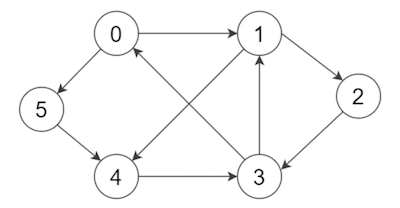

**Attention as Communication:**

Attention is a way for tokens (nodes) to communicate by computing **weighted averages** of others’ vectors. Each token updates itself based on **how relevant** other tokens are—determined **dynamically** through dot products between queries and keys.

---

**Graph Structure (Autoregressive Masking):**

In our setup:

* We have 8 tokens (block size = 8).
* Token 0 attends only to itself.
* Token 1 attends to tokens 0 and 1.
* Token 2 attends to tokens 0, 1, and 2.
* ...
* Token 7 attends to all previous tokens and itself.

This structure is enforced using a **lower-triangular matrix** (`tril`) to **mask future tokens**, ensuring autoregressive behavior.

```python
wei = wei.masked_fill(tril == 0, float('-inf'))
```

---

**Batch Dimension:**

Each element in a batch is processed **independently**—no attention across batch entries.
So, with a batch size of 4 and 8 tokens each, you're effectively running **4 isolated attention graphs** in parallel.

```python
wei = q @ k.transpose(-2, -1)
```

This is a **batched matrix multiplication**, run separately for each batch.

---

**Why Positional Encoding:**

Attention operates over a **set of vectors** without knowing their positions.
Unlike convolutions (which assume a fixed layout), attention needs **positional encodings** so that tokens can **learn their order** or **relative distance** in the sequence.

---

**Encoder vs Decoder Attention Blocks:**

* **Decoder (Autoregressive):** uses the mask → can't see future tokens
  → e.g., language modeling.

* **Encoder (Bidirectional):** no mask → full attention allowed
  → e.g., sentiment classification, translation encoding.

The **masking decision depends on the task**, not the mechanism itself.

---

**Self-Attention vs Cross-Attention:**

* **Self-Attention:**
  All queries, keys, and values come from the same input (`x`).
  Tokens attend to themselves and each other.

* **Cross-Attention:**
  Queries come from one input (`x`)
  Keys and values come from a **separate** source (`y`).
  Used in encoder-decoder models (e.g., in machine translation).

---

**The Scaled Dot-Product Attention Formula:**

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V
$$

* $Q, K, V$: Query, Key, and Value matrices
* $d_k$: dimensionality of the key vectors (head size)
* We already implemented most of this
* The missing part is the **scaling** by $\sqrt{d_k}$

**Why scale by** $\sqrt{d_k} $?

Without it, dot products can become large in magnitude when $d_k$ is high → leading to small gradients when softmax saturates.
The scaling helps **stabilize training**.



In [40]:
torch.manual_seed(1337)
B,T,C = 4, 8, 32 # batch, time, channels(embedding)
head_size = 16

k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1)

out = wei @ v

q.var(), q.std(), k.var(), k.std(), wei.var(), wei.std()

(tensor(1.0594),
 tensor(1.0293),
 tensor(1.0877),
 tensor(1.0429),
 tensor(18.4436),
 tensor(4.2946))

In [41]:
k.shape, k.std()

(torch.Size([4, 8, 16]), tensor(1.0429))

In [42]:
torch.manual_seed(1337)
B,T,C = 4, 8, 32 # batch, time, channels(embedding)
head_size = 16

k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

q.var(), q.std(), k.var(), k.std(), wei.var(), wei.std()

(tensor(1.0594),
 tensor(1.0293),
 tensor(1.0877),
 tensor(1.0429),
 tensor(1.1527),
 tensor(1.0737))


#### Why It's Important That `wei` Is Diffuse Before Softmax

When we compute attention weights:

```python
wei = F.softmax(wei, dim=-1)
```

…the `softmax` turns raw scores into **probabilities** — telling us **how much attention** each token pays to every other token.

---

#### Problem at Initialization

If the values inside `wei` (before softmax) are **too extreme** — meaning:

* Some values are **very large** (e.g. 10, 20, 30)
* Others are **very small/negative** (e.g. -10, -20)

…then **softmax will output something close to a one-hot vector**


In [43]:
wei = F.softmax(wei, dim=-1)
out = wei @ v

In [44]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, 0.2, 0.5]), dim=-1)

tensor([0.1799, 0.1333, 0.2197, 0.1988, 0.2684])

In [45]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, 0.2, 0.5]) * 80, dim=-1)

tensor([1.2664e-14, 4.7809e-25, 1.1254e-07, 3.7751e-11, 1.0000e+00])

## Multi-Head Attention

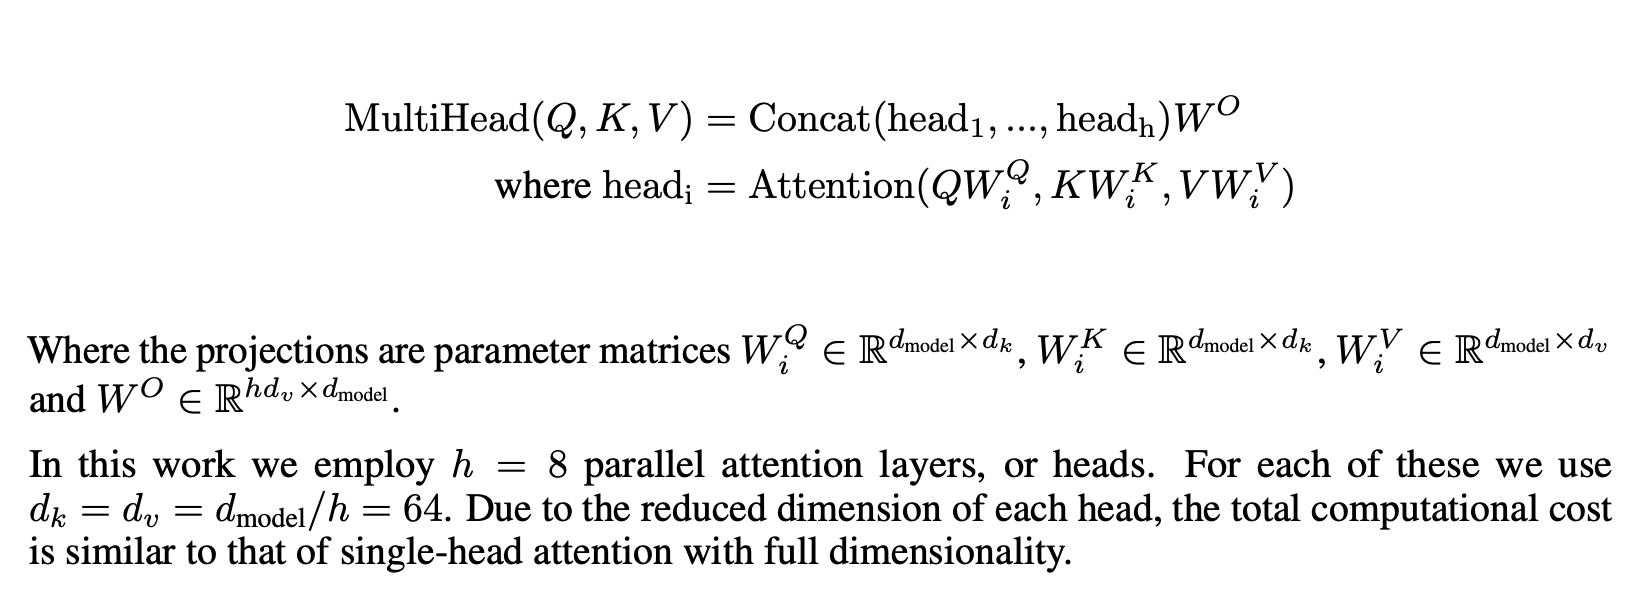

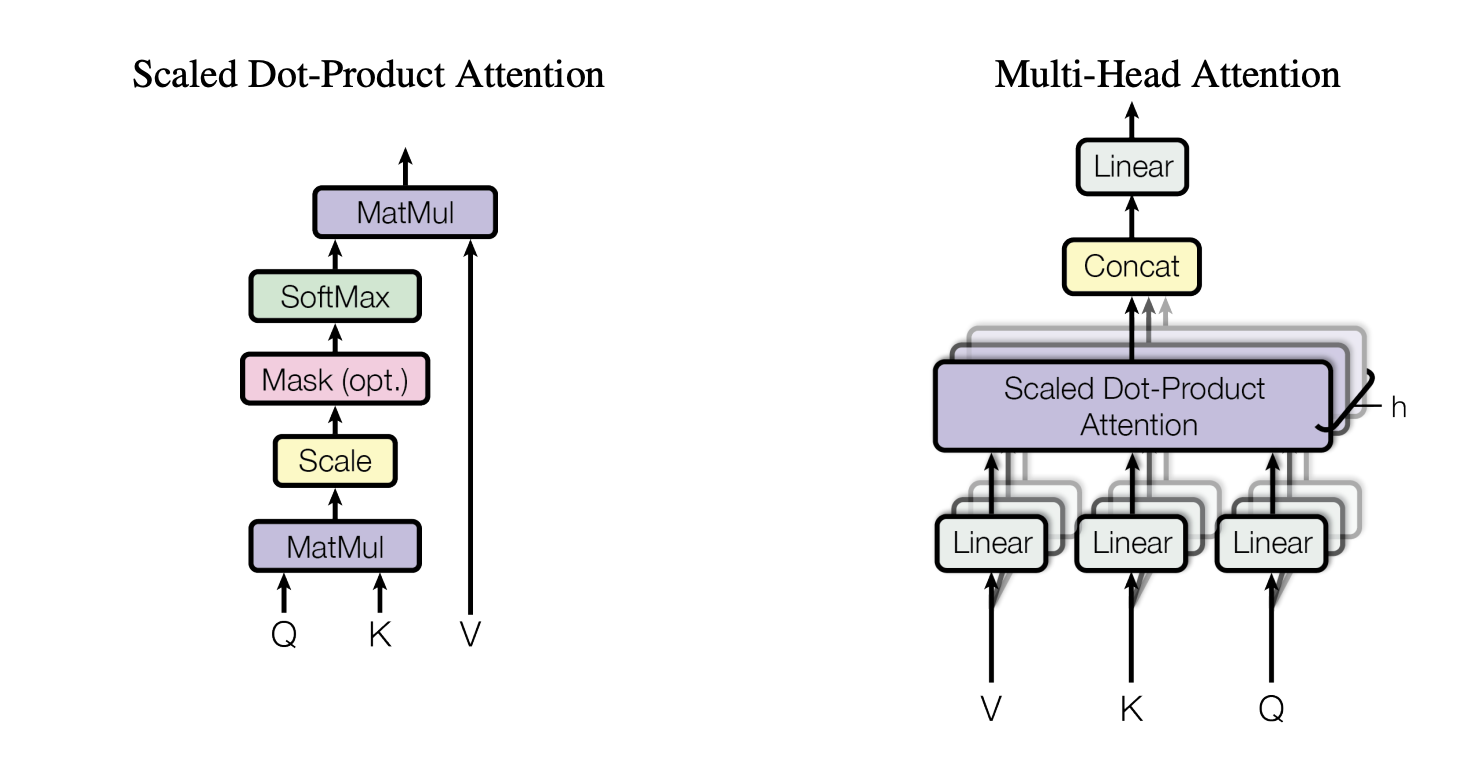

We now also introduce positional encoding

In [46]:
n_embd = 32

### `BigramLanguageModel` Architecture (with Multi-Head Self-Attention):



```python
class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Token embeddings: maps vocab tokens to n_embd-dimensional vectors
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)

        # Positional embeddings: one unique vector for each position in the sequence
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        # Multi-head self-attention: 4 heads, each with n_embd // 4 = 8 dims
        self.sa_heads = MultiHeadAttention(4, n_embd // 4)

        # Final projection: transforms output embeddings back to vocab logits
        self.lm_head = nn.Linear(n_embd, vocab_size)
```

---

### Why 4 Heads of 8 Dimensions?

* `n_embd = 32` (embedding size of each token)
* We split this into 4 attention heads

  * Each head gets `n_embd // 4 = 8` dimensions
* Each head computes attention **independently**

  * Think of each head as a separate channel that learns a different "view" of the data
* At the end, we **concatenate** the outputs from all 4 heads:

  * `4 × 8 = 32` → back to the original embedding size

---

### Analogy: Group Convolutions

* This is like **grouped convolutions** in CNNs:

  * Instead of one large convolutional operation over all features,
  * you divide the input into groups, apply smaller convolutions separately, then merge the results.
* Similarly, here we divide the embedding into chunks, apply attention per chunk (head), then merge.



### Why Multiple Attention Heads Help



Think of each attention head as a **communication channel** between tokens.

* Tokens aren't just interested in one kind of relationship.
  They want to:

  * Find **vowels**
  * Detect **consonant patterns**
  * Look at **punctuation**, **repetition**, **rhythm**, etc.
  * Notice patterns **at different positions** in the context

> One head can't focus on all these things at once. It's like trying to listen to multiple conversations through one ear.

---

### So What Do We Do?

We give them **multiple ears (heads)**:

* Each attention head can specialize:

  * One head learns to look for **rhyme**
  * Another focuses on **subject-verb relationships**
  * Another watches for **spacing and punctuation**

Then we:

* Let each head do its thing independently
* **Concatenate** their outputs
* Feed the combined representation into the next layer for decoding

---

### Analogy:

> Think of it like a team of experts analyzing the same sentence — each expert looks for something different. Later, they all report their findings so the model can make a smarter decision.

This is why **multi-head attention** is so powerful: it gives the model a **richer, more diverse understanding** of the input — and that's exactly what makes Transformers so expressive.


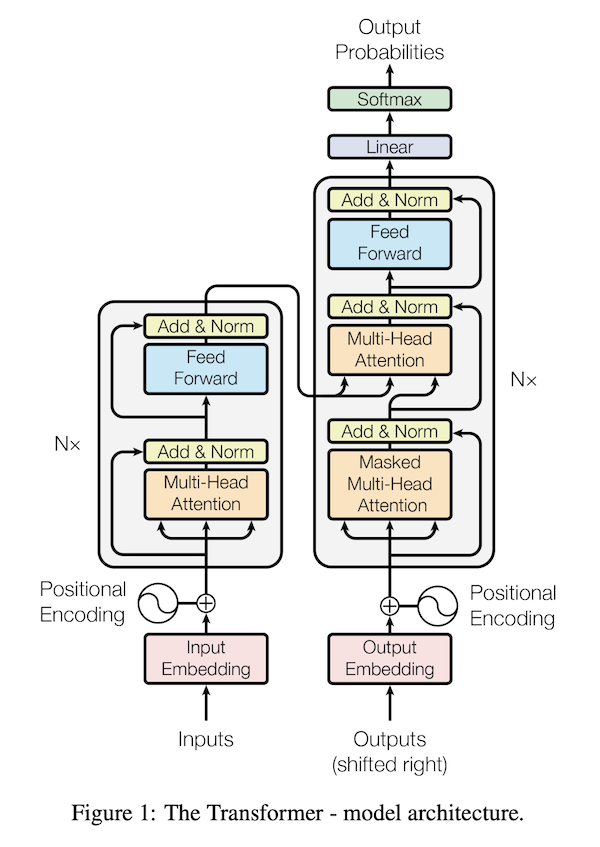

### What we already implemented:

* **Positional encodings**: to help the model understand the order of tokens in the input.
* **Masked Multi-Head Self-Attention**: so each token only attends to past and present tokens, not future ones.

---

### Feed Forward Block (FFN)

Now we’ll add another key component of the Transformer architecture: the **Feed Forward Network** (FFN).
This block adds extra computation to each token’s embedding — **independently** of the others.

> 💡 This is often called a “position-wise feed-forward network” because the same network is applied independently at each position in the sequence.

---

### Mathematically:

The formula looks like this:

$$
\text{FFN}(x) = \text{ReLU}(xW_1 + b_1)W_2 + b_2
$$

It’s just a **two-layer MLP** with a ReLU activation between them.

---

### What we’re *not* going to implement:

* **Cross-attention**, as used in encoder-decoder models (like in machine translation). We're only building a **decoder-style** Transformer (like GPT).

---

### What we’re doing next:

We’ll implement this small feed-forward block:

```python
class FeedForward(nn.Module):
    """" a simple linear layer followed by a non-linearity"""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
```

### Key Points:

* The `FeedForward` block works **per token**, independently of all others.
* Each token’s embedding is passed through the **same MLP** (same weights).
* This adds **non-linearity** and helps the model learn more complex transformations beyond attention (branches, activations, interaction)

**self-attention:** communication (between tokens)
**feed-forward:** computation (withing each token)



# Big Picture: How Transformers Think



Transformers alternate between **talking** (self-attention) and **thinking** (feedforward computation). This forms the basic **block** used in deep Transformer architectures.

---

### Inside a `Block`:

```python
class Block(nn.Module):
    """Transformer block: communication followed by computation"""

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head  # Split embedding dimension across heads
        self.sa = MultiHeadAttention(n_head, head_size)  # Communication layer
        self.ffwd = FeedForward(n_embd)                  # Computation layer
    
    def forward(self, x):
        x = self.sa(x)    # Tokens share info (attention)
        x = self.ffwd(x)  # Each token processes its own info
        return x
```

* `n_embd`: total number of features per token (e.g. 32)
* `n_head`: number of attention heads (e.g. 4)
* `head_size = n_embd // n_head` → 4 heads × 8 dims = 32

---

### Stack of Blocks in `BigramLanguageModel`:

```python
self.blocks = nn.Sequential(
    Block(n_embd, n_head=4),
    Block(n_embd, n_head=4),
    Block(n_embd, n_head=4)
)
```

You're stacking **3 Transformer blocks**, which means:

* Tokens can communicate multiple times (deeper interactions)
* Each time, the model learns more abstract representations

---

### Analogy

Imagine a classroom of students (tokens):

* **Self-attention**: Students whisper to each other and gather ideas from past context.
* **Feedforward**: Each student thinks privately based on what they just heard.

This alternation helps build up nuanced understanding over multiple layers.

---

Next steps (usually):

* Add **residual connections** (`x + ...`) so information can flow through more easily
* Add **layer normalization** for training stability



### Where we are now:

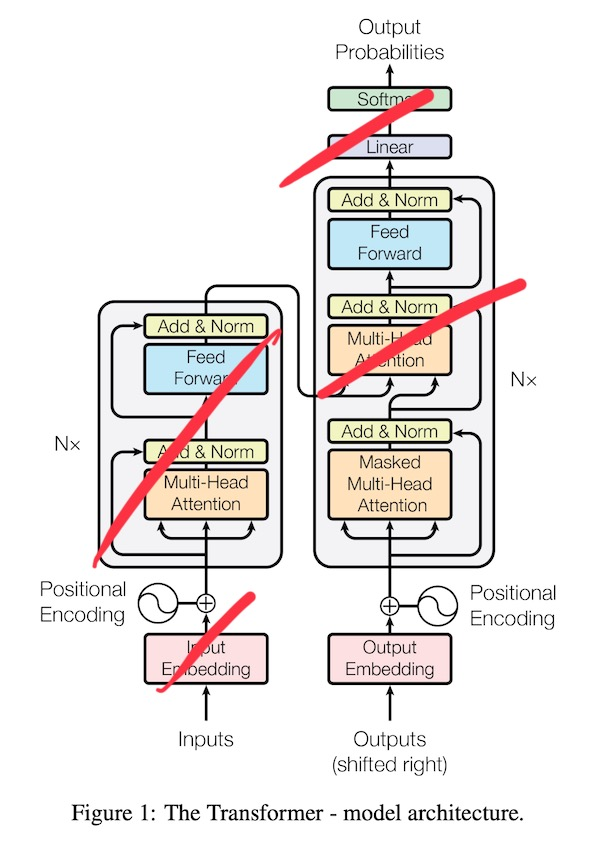



...what i crossed out is the 'Cross-Attention'

## Residual connections - Projection Layer

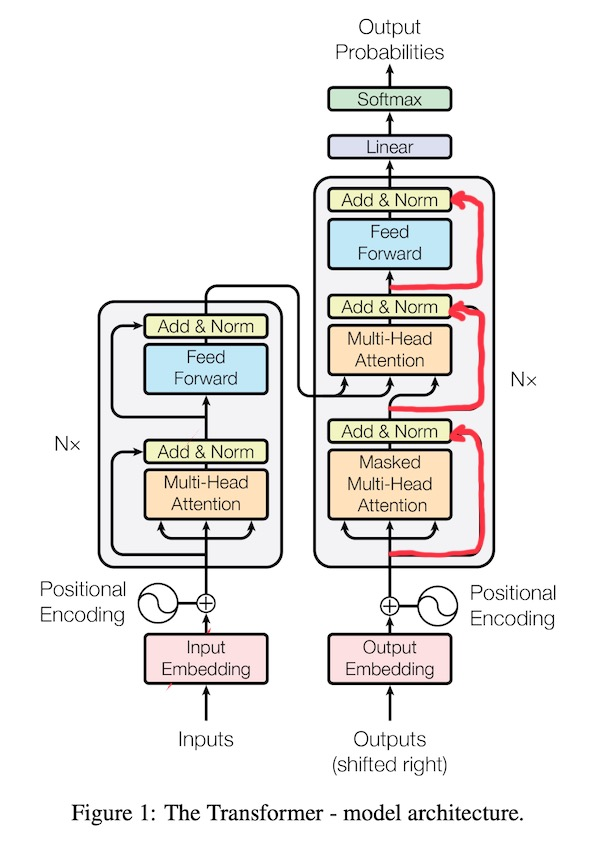

### Why Residual Connections?

> “You either go straight, or fork off, compute something, then come back.”

Residuals are used to:

* **Bypass** computation and directly carry input forward.
* Create a **gradient superhighway** — letting gradients flow backward without vanishing.
* Encourage **stability during training**, especially early on (when layers are near-zero).

### Transformer Block Summary

Each block now has:

* **Multi-Head Self-Attention** (communication)
* **FeedForward MLP** (computation)
* **Residual connection** around each

### Code Recap with Comments

#### `Block` (Communication + Computation + Residual)

```python
class Block(nn.Module):
    """Transformer block: communication + computation with residuals"""

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)  # multiple heads of self-attention
        self.ffwd = FeedForward(n_embd)                  # position-wise feedforward network

    def forward(self, x):
        x = x + self.sa(x)      # residual around self-attention
        x = x + self.ffwd(x)    # residual around feedforward
        return x
```

---

#### `MultiHeadAttention`: multiple Heads + projection

```python
class MultiHeadAttention(nn.Module):
    """Multiple self-attention heads + projection back to model dimension"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)  # projection back to embedding dim

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # concat over channels
        out = self.proj(out)  # project back to original dimension (n_embd)
        return out
```

---

#### `FeedForward`: computation per token

```python
class FeedForward(nn.Module):
    """Position-wise MLP with expansion for more capacity"""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # expand to 4x hidden size
            nn.ReLU(),                      # non-linearity for expressive power
            nn.Linear(4 * n_embd, n_embd),  # project back down
        )

    def forward(self, x):
        return self.net(x)
```

---

### Why the Expansion in FeedForward?

* Adds **computational capacity**.
* Allows **non-linear mixing** of the token features.
* Follows the original Transformer paper:

  > "Each position gets its own small MLP, expanding and then reducing the dimensionality."

---

### Summary

Your Transformer block now mirrors what real Transformer models do:

* Multiple heads → diverse attention patterns
* Projection → back to model space
* FeedForward → deep token-wise computation
* Residuals → keep gradient flow strong and help with convergence



### Additional representations

Residual Connection form Feed Forward Layer

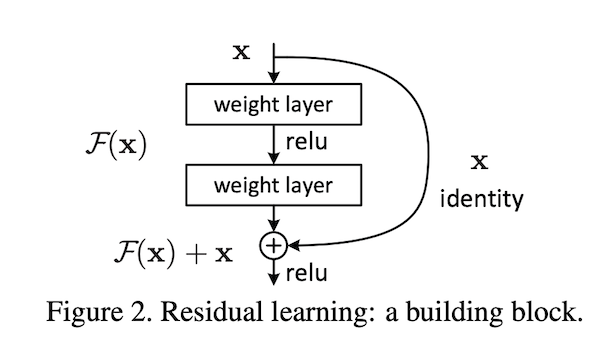

Types of Residual Blocks

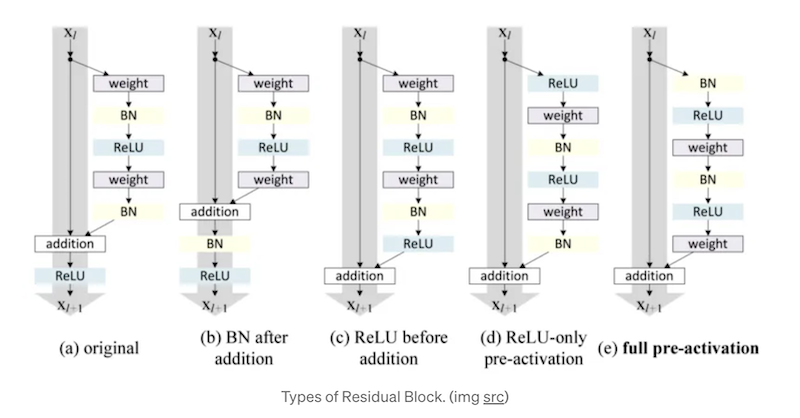

## 'Add & Norm' - Layer Normalization

$y = \frac{x - E[x]}{\sqrt{Var[x] + ϵ}} * γ + β$

read paper about [Layer-Normalization](https://arxiv.org/abs/1607.06450)

In [47]:
class LayerNorm:

  def __init__(self, dim, eps=1e-5, momentum = 0.1):
    self.eps = eps
    #parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)


  def __call__(self, x):
    #calculate the forward pass
    xmean = x.mean(1, keepdim = True) # batch mean
    xvar = x.var(1, keepdim = True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta # we use .out for visualization later
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]


torch.manual_seed(1337)
module = LayerNorm(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

### What You’ve Just Built:

You’ve implemented **Layer Normalization**, which:

* Normalizes **across the features of each token individually** (i.e., across **each row** of your batch),
* Instead of normalizing across the **batch dimension** like BatchNorm.

---

### Why LayerNorm in Transformers?

#### Transformers don’t use BatchNorm because:

* **BatchNorm depends on the batch** — but in NLP, sequence lengths vary and you often have **batch size = 1** at inference.
* LayerNorm works **per token**, so it’s independent of batch size.

### Transformer “Block” structure uses:

> **Add & Norm = Residual Connection + LayerNorm**

So now your Transformer block looks like this (in logic, not code yet):

```
x = x + self_attn(x)
x = LayerNorm(x)
x = x + feed_forward(x)
x = LayerNorm(x)
```

Each residual path is followed by **LayerNorm** to keep the model **stable during training**.

---

### Output Check in Your Code:

Comparing Batch-Norm and Layer-Norm:
```python
x[:, 0].mean(), x[:, 0].std() # mean and std of a single feature across the batch (column)
x[0, :].mean(), x[0, :].std() # mean and std of a single sample (row)
```

#### Observation:

* After **BatchNorm**: `x[:, 0]` (one feature across the batch) is normalized.
* After **LayerNorm**: `x[0, :]` (all features of one token) is normalized.

---

### Wrap-up: You're Now at Decoder-only Transformer!

By adding:

* **Positional encoding**
* **Masked multi-head attention**
* **Feedforward network**
* **Residual connections**
* **LayerNorm**

### What Changed: **Post-Norm vs. Pre-Norm**


---


In the **original Transformer paper (Vaswani et al., 2017)**:

* LayerNorm was applied **after** each sub-layer (e.g., attention or feedforward).

  > This is called **Post-Norm**:

  ```python
  x = x + sublayer(x)
  x = LayerNorm(x)
  ```

But in **modern Transformer implementations**, we usually apply **LayerNorm before** the sublayer.

> This is called **Pre-Norm**:

```python
x = x + sublayer(LayerNorm(x))
```

---

#### Why Pre-Norm is preferred today:

1. **Better gradient flow**
   Pre-Norm leads to **more stable training**, especially for **deep transformers**.

2. **Easier to train with fewer tricks**
   Post-Norm often required **learning rate warmup, careful init**, etc.

3. **Empirically better performance**
   Many libraries (e.g., Fairseq, T5, GPT-2+) now use Pre-Norm.

---

#### 🔧 So in code, your `Block` forward becomes:

```python
class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = LayerNorm(n_embd)
        self.ln2 = LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))   # PreNorm
        x = x + self.ffwd(self.ln2(x)) # PreNorm
        return x
```

---

If you're building a GPT-like model or decoder-only transformer, **Pre-Norm is the standard today**.

# Dropout

## What Dropout Really Does:

Dropout is a **regularization technique** that prevents neural networks from **overfitting** by:

> Randomly "dropping out" (i.e., setting to zero) a subset of neurons **during training only**.

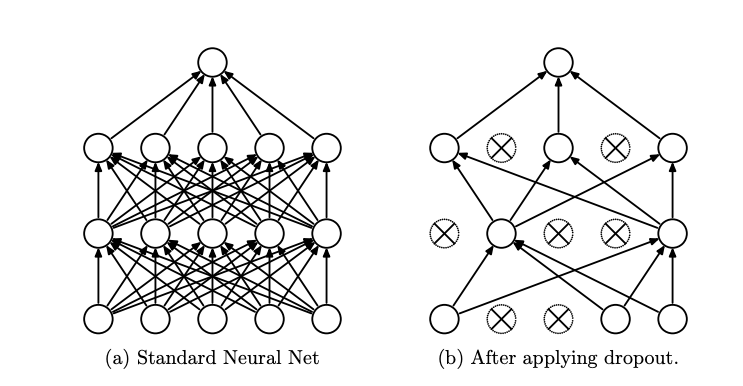



---

## How It Works:

### During **training**:

* For each forward pass, a different random set of neurons is **disabled (zeroed out)**.
* The network **cannot rely on any single path** — it must learn **redundant, robust representations**.
* Think of it like training **many slightly different neural nets** (a.k.a. "sub-networks") at once.

### During **inference** (test time):

* No neurons are dropped.
* All neurons are **fully active**.
* The outputs are **scaled down appropriately** to match the expected values (because more neurons are now contributing).

---

## Why It Helps:

* Prevents **co-adaptation** of neurons (neurons relying too much on each other).
* Encourages the network to **generalize** better to unseen data.
* Acts like **model ensembling**, but very cheap to implement.

---

## PyTorch Implementation

Use `nn.Dropout(p)` where `p` is the probability to drop a unit:

```python
self.dropout = nn.Dropout(0.2)  # 20% dropout

def forward(self, x):
    x = self.dropout(x)
    ...
```

---

## Dropout Placement

Typically used:

* After activations (e.g., after ReLU)
* After attention blocks or feedforward layers
* Before projecting to logits (optionally)

In Transformers, you'll often see something like:

```python
self.dropout = nn.Dropout(0.1)

def forward(self, x):
    x = self.dropout(self.sa(x))
    ...
```



# Transformer Decoder Components — As Implemented




### **Token & Positional Embedding**

```python
self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
self.position_embedding_table = nn.Embedding(block_size, n_embd)
```

* Turns token indices into dense vectors (`n_embd`-dim).
* Adds **position information** so the model knows where each token is.

---

### **Stack of Transformer Blocks**

```python
self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
```

* Repeats the **Block** structure `n_layer` times.
* Each block = **Multi-Head Attention** (communication) + **FeedForward** (computation) + **residuals** + **layernorms**.

---

## Inside Each `Block`

```python
class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    
    def forward(self, x):
        x = x + self.sa(self.ln1(x))  # PreNorm + Residual
        x = x + self.ffwd(self.ln2(x))
        return x
```

* **LayerNorm** is applied *before* each sublayer (PreNorm).
* **Residual connection** adds the original input `x` after each sublayer.
* **Dropout** (inside attention and FFN) helps prevent overfitting.

---

## MultiHeadAttention

```python
self.proj = nn.Linear(head_size * num_heads, n_embd)
self.dropout = nn.Dropout(dropout)
```

* Each `Head` transforms the input into **key, query, value**.
* Attention scores are softmaxed → control **communication strength** between tokens.
* **Dropout on attention weights** and final projection output helps regularize.

---

## FeedForward Network

```python
self.net = nn.Sequential(
    nn.Linear(n_embd, 4 * n_embd),
    nn.ReLU(),
    nn.Linear(4 * n_embd, n_embd),
    nn.Dropout(dropout),
)
```

* Adds **non-linearity** and **expands the representation** temporarily.
* Dropout here prevents overfitting at the computation level.

---

## Final LayerNorm

```python
self.ln_f = nn.LayerNorm(n_embd)
```

* This is applied **after** all blocks, right before prediction.
* Optional but common in transformer architectures (e.g., GPT).

---

## Final Output

```python
self.lm_head = nn.Linear(n_embd, vocab_size)
```

* Maps the final hidden state back to vocabulary logits.
* Used for predicting the **next token**.

---



## Setting new Hyper Parameters

The model with following parameters Karpathy was running on a A100. This took him 15 minutes. He not recommends to train that model on MacBook :P

For running on CPU Karpathy recommends to brake down the number of layers and the emb_d.

```
batch_size = 64 # 4 #64 # how many independent sequences will we process in parallel?
block_size = 256 #8 # 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384 # 10 # 384 # number of embedding dimension = channels
n_head  = 6
n_layer = 6
dropout = 0.2
# -----------------
```

```
learning_rate = 3e-4
# now much lower as the network is much deeper

n_embd = 384
n_head = 6

# 384 / 6 = 64 means: every head is 6 dimensional

dropout = 0.2
# 20% of intermediate calculation are disabled and dropped to zero
```

This is the output: (for the model trained with A100)

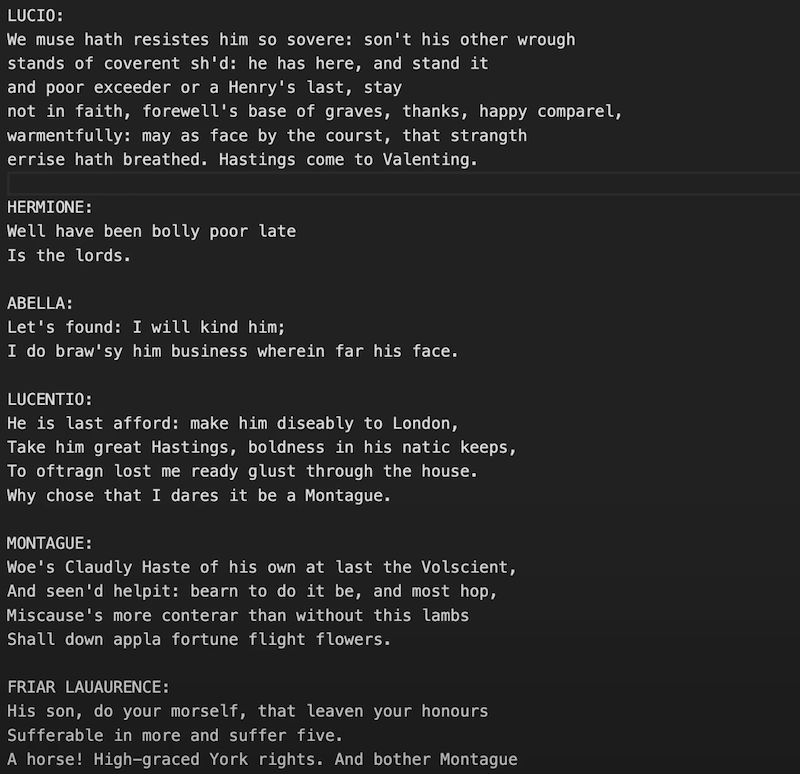

# What We Implemented vs. What the Original Transformer Paper Described

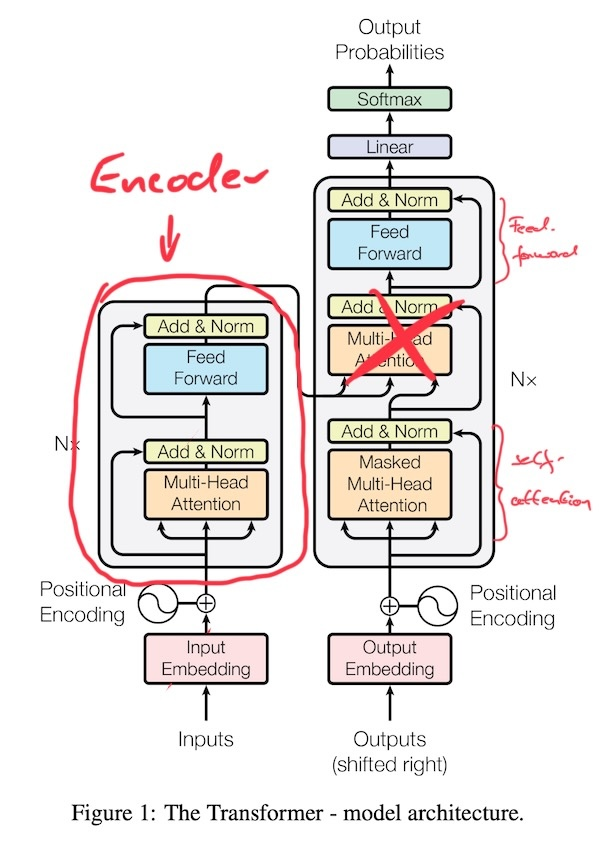

We built a **Decoder-only Transformer**, similar to GPT models.
The original paper, *'Attention is All You Need'*, introduced a **full encoder-decoder architecture**, which we **partially implemented**.

---

### What We Built

* **Only the decoder part**
* Implemented:

  * **Self-Attention with causal masking** (triangular mask)
  * **Feed-Forward layers**
  * **Residual connections + LayerNorm**
* **No encoder**, **no cross-attention**

> **We just generate text, unconditionally.**
> The model is trained to predict the next token based only on the past tokens.
> It learns to "blabber on" in a statistically likely way, based on a training dataset.

---

### What Makes It a Decoder?

* We use a **triangular mask** (`tril`) in self-attention → prevents "peeking into the future"
* The model is **autoregressive**: it can only see previous tokens when predicting the next
* This allows **sampling one token at a time**, like GPT does

---

### Why the Original Transformer Paper Used Encoder–Decoder

That paper targeted **machine translation**.

* The task: Convert a sentence from one language (e.g., French) into another (e.g., English)
* This needs **conditioning**: You need to **read the source sentence** before you can generate a translation

---

### How Encoder–Decoder Works

```
# French to English translation example:
#<--------------ENCODE---------------><---------------DECODE------------------>
#les réseaux de neurones sont géniaux!<START> neural networks are awesome!<END>
```

* The **encoder** reads the full source sentence (French)
  → It uses full **self-attention without masking**, so every word can attend to every other word.
* The **decoder** generates the target sentence (English)
  → It uses **masked self-attention** to preserve autoregressiveness.
* **Cross-Attention** in each decoder block allows the decoder to attend to the encoder’s output.

  * **Queries** come from decoder states
  * **Keys and Values** come from the encoder output

> **Cross-Attention enables the decoder to condition its generation on the fully encoded input sequence.**

---

### Decoder-only (like GPT) vs. Encoder–Decoder (like T5, original Transformer)

| Feature          | Decoder-Only (GPT)               | Encoder–Decoder (T5, original paper)   |
| ---------------- | -------------------------------- | -------------------------------------- |
| Input            | Prompt (in same language)        | Source language (e.g., French)         |
| Output           | Continuation                     | Translation or answer                  |
| Cross-Attention? | ❌ No                             | ✅ Yes                                  |
| Use case         | Text generation, auto-completion | Translation, summarization, QA         |
| Masking          | Causal mask (tril)               | Encoder: no mask, Decoder: causal mask |

---

### Summary
> A **decoder-only Transformer** is a stack of masked self-attention and feed-forward layers that only relies on the past context to predict the future. It is autoregressive and generates text unconditionally, one token at a time. Unlike the encoder-decoder model used in the original Transformer paper, it does not use cross-attention and does not condition generation on external input sequences. This architecture is the foundation of models like GPT.



# NanoGPT Overview


NanoGPT is a **minimalistic** yet **production-level** implementation of GPT, built by Andrej Karpathy.
It retains the **core architecture** of a decoder-only Transformer — like we implemented — but adds all the engineering needed for real-world training.

**GitHub Repo**: [github.com/karpathy/nanoGPT](https://github.com/karpathy/nanoGPT)

---

## Key Files

### 1. `train.py`

Handles:

* Model instantiation and training
* Advanced engineering:

  * **Saving & loading checkpoints**
  * **Learning rate scheduling (cosine decay)**
  * **Mixed precision** for speed/memory
  * **Distributed training** across GPUs/nodes
  * **Weight initialization**, optimizer config, and tokenizer setup

> Compared to our course code:
>
> * More complex because it's made to train **large models efficiently**
> * But **core training loop** logic remains the same

---

### 2. `model.py`

Implements the actual Transformer model.

#### Similarities:

* Same Transformer **architecture**:

  * Token & positional embeddings
  * Stacked Transformer blocks
  * Each block: **(LayerNorm / Self-Attention / MLP / residual connections)**

#### Differences and Improvements:

##### Multi-Head Attention:

* **Our version**:

  * Implemented multiple `Head` modules, each with its own linear layers
  * Explicitly **loop over heads** and **concatenate outputs**

* **NanoGPT version**:

  * Implements attention in a **batched, fused way**:

    * Heads are handled by reshaping tensors: shape `(B, T, nh, hs)`
    * This improves **speed and GPU efficiency**
    * Mathematically **identical** — just a better engineering implementation

##### MLP (FeedForward):

* Uses `GELU` non-linearity instead of ReLU

  * GELU ≈ smoother and empirically better than ReLU
  * Used in **OpenAI's GPT models**
  * This choice makes **NanoGPT compatible with loading OpenAI checkpoints**

##### TransformerBlock:

* Identical to what we built conceptually

##### Parameter Grouping:

* NanoGPT carefully separates parameters into:

  * Those that should use **weight decay** (e.g. weights of linear layers)
  * Those that **shouldn’t** (e.g. biases, LayerNorm scales)
* This is important for **L2 regularization** and training stability

##### Generate Function:

* Almost identical
* Given a prompt, iteratively predicts and samples the next token
* Implements **autoregressive decoding** loop

---

## Summary: What NanoGPT Adds

| Feature                | Ours                             | NanoGPT                                  |
| ---------------------- | -------------------------------- | ---------------------------------------- |
| Architecture           | ✅ Basic decoder-only Transformer | ✅ Same core, more efficient              |
| Training on GPU        | ❌ CPU-only or single GPU         | ✅ Multi-GPU support via DDP              |
| Attention              | Manual, head-by-head             | ✅ Fused, batched, efficient              |
| MLP Activation         | ReLU                             | ✅ GELU                                   |
| Dropout, LayerNorm     | ✅                                | ✅                                        |
| Optimizer tuning       | Simple Adam                      | ✅ Parameter grouping, weight decay, etc. |
| Generation             | ✅ Simple loop                    | ✅ Same logic, production-ready           |
| Tokenizer              | Basic char-level                 | ✅ BPE (OpenAI compatible)                |
| Checkpoints            | ❌                                | ✅ Save/load                              |
| Learning rate schedule | ❌ Fixed LR                       | ✅ Cosine decay                           |
| Compilation            | ❌                                | ✅ torch.compile for speed                |

---

## Why NanoGPT Matters

* It’s **not just a toy** — it’s ready to **train real GPT models** (on your own data)
* It’s a **perfect bridge** between learning and deploying real-world models
* It reflects **real engineering** decisions OpenAI and others make




# How Our Tiny Transformer Relates to ChatGPT


##  Two Stages of Training Large Language Models

ChatGPT (and other GPT models) are trained in **two major stages**:

---

## 1. Pre-Training

This is where the model learns **language from scratch**.

> **Goal**: Train a **decoder-only Transformer** to predict the next token, given all previous ones.
> Same autoregressive objective we implemented in our Shakespeare model.

### What We Did (on a small scale)

* Trained on tiny Shakespeare dataset
* \~10 million parameters
* Used basic character-level tokenizer
* Model learns to **babble Shakespeare-like text**

### What OpenAI Did (at scale)

* Trained on **hundreds of billions of tokens** from the Internet (e.g., books, websites, forums)
* Tokenizer: **Byte-Pair Encoding (BPE)**, with \~50,000 tokens
* Model sizes:

  * GPT-3: 175 billion parameters
  * Embedding dim: 12,288
  * Head size: 128
  * \~96 layers, 96 attention heads
* Training done over **thousands of GPUs**, communicating in parallel

### Limitations of the Pre-Trained Model

> A model at this stage is **not yet helpful** or aligned with human values.

* It can:

  * Generate fluent and plausible text
  * Complete documents, code, dialogue...
* But:

  * It might be misleading, toxic, or unhelpful
  * It has no intention or purpose — it just **completes prompts**
  * If you ask a question, it might continue with **more questions**, not answers

This model is **just a statistical document completer** — it has no idea what being an assistant means.

---

## 2. Fine-Tuning (Alignment)

This stage **transforms the raw language model into a helpful assistant.**

OpenAI describes this process in [this blog post](https://openai.com/index/chatgpt/).

### Three Steps of Fine-Tuning

---

### **Step 1: Supervised Fine-Tuning (SFT)**

> Teach the model how an assistant *should* behave.

* Curate **high-quality Q\&A datasets**, where:

  * The **question is on top**, and
  * A good **assistant-style answer** follows
* Thousands of examples
* The model fine-tunes to better **predict human answers** to prompts
* This gives us a **first assistant model**
  (It still may not be perfect)

---

### **Step 2: Train a Reward Model (RM)**

> Use human preferences to teach the model *what good answers look like*.

* Show humans multiple model responses to the same question
* Annotators **rank the responses** from best to worst
* These rankings are used to train a **Reward Model**:

  * It learns to predict a **scalar reward score** for any output

---

### **Step 3: Reinforcement Learning (PPO)**

> Use RL to improve the model's behavior based on the Reward Model.

* Fine-tune the assistant model using **Reinforcement Learning**
  (specifically, **PPO = Proximal Policy Optimization**)
* The model generates responses (a “policy”), and gets feedback from the **Reward Model**
* The goal is to **maximize reward** — i.e., generate better answers
* Result: The model improves its helpfulness, honesty, and harmlessness

---

## 🔄 Summary: From Tiny GPT to ChatGPT

| Stage        | What We Did             | What OpenAI Did               |
| ------------ | ----------------------- | ----------------------------- |
| Pre-Training | Shakespeare, 10M params | Internet-scale, 175B+ params  |
| Objective    | Predict next character  | Predict next token            |
| Result       | Babbling text generator | Document completer            |
| Fine-Tuning  | ❌ Not done              | Supervised, Reward Model, PPO |
| Result       | ❌                       | Helpful assistant (ChatGPT)   |

